# AiiDA 
This implementation uses AiiDA to implement the equation of state workflow with Quantum ESPRESSO.
It intentionally provides a minimal implementation for the sake of simplicity:

* Quantum ESPRESSO is run locally, but could be run on a remote cluster
* Not all steps of the procedure are capture by provenance, just the Quantum ESPRESSO calculations
* The entire procedure is not yet wrapped up in a single workflow
* The SCF calculations are run serially but could be run in parallel

## Installation and setup
```
pip install aiida-shell
verdi presto
```


In [12]:
import pathlib
import tempfile
import typing as t
import matplotlib.pyplot as plt
from ase import Atoms
from ase.build import bulk
from ase.io import read, write
from aiida import orm, load_profile
from aiida_shell import launch_shell_job

In [13]:
FILEPATH_PSEUDOS = pathlib.Path.cwd() / 'espresso' / 'pseudo'

def generate_scaled_structures(structure: Atoms, scaling_factors: list[float]) -> dict[str, Atoms]:
    scaled_structures = {}

    for index, scaling_factor in enumerate(scaling_factors):
        atoms = structure.copy()
        atoms.set_cell(atoms.get_cell() * scaling_factor, scale_atoms=True)
        scaled_structures[f's_{index}'] = atoms

    return scaled_structures

def create_pw_input_file(structure: Atoms, inputs: dict[str, t.Any]) -> str:
    with tempfile.NamedTemporaryFile(suffix='.pwi', mode='w+') as handle:
        write(
            filename=handle.name,
            images=[structure],
            **inputs
        )
        return handle.read()

def parse_pw_output_file(output: str) -> dict[str, Atoms | float]:
    atoms = read(output, format='espresso-out')
    return {'structure': atoms, 'energy': atoms.calc.results['energy']}

def run_pw(structure: Atoms, inputs: dict[str, t.Any]) -> dict[str, Atoms | float]:
    script = create_pw_input_file(structure, inputs)

    results, _ = launch_shell_job(
        'pw.x',
        arguments='-in {script}',
        nodes={
            'script': orm.SinglefileData.from_string(script),
        },
        metadata={
            'options': {
                'prepend_text': f'export ESPRESSO_PSEUDO {FILEPATH_PSEUDOS.as_posix()}'
            }
        }
    )

    with results['stdout'].open() as handle:
        return parse_pw_output_file(handle)

def plot_energy_volume_curve(structures: list[Atoms], energies: list[float]) -> None:
    """Function to plot the final graph"""
    volumes = [structure.get_volume() for structure in structures]
    plt.plot(volumes, energies)
    plt.xlabel('Volume')
    plt.ylabel('Energy')
    plt.savefig('evcurve.png')

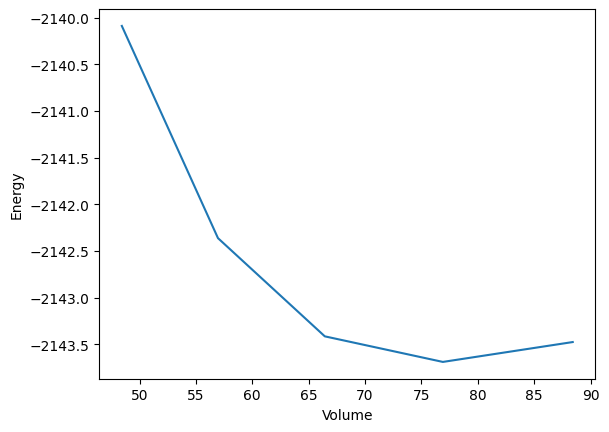

In [14]:
load_profile()
atoms = bulk('Al', a=4.05, cubic=True)
scaling_factors = [0.9, 0.95, 1.0, 1.05, 1.1]
inputs = {
    'Crystal': True,
    'kpts': (1, 1, 1),
    'input_data': {
        'calculation': 'relax',
        'occupations': 'smearing',
        'degauss': 0.02,
    },
    'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'},
    'tstress': True,
    'tprnfor': True
}

results_relax = run_pw(atoms, inputs)
scaled_structures = generate_scaled_structures(results_relax['structure'], scaling_factors)

structures = []
energies = []
inputs['input_data']['calculation'] = 'scf'

for scaled_structure in scaled_structures.values():
    results_scf = run_pw(scaled_structure, inputs)
    structures.append(results_scf['structure'])
    energies.append(results_scf['energy'])

plot_energy_volume_curve(structures, energies)

## Submission to an HPC / Check pointing / Error handling
To be added...

## Data Storage / Data Sharing
To be added...

## Publication of the workflow
To be added...